# Código para extraer las características de todo un dataset

In [1]:
# Importamos las librerías necesarias 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage.measure import label, regionprops
from scipy.stats import kurtosis, skew
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import math

## Celdas de debugging inicial

In [2]:
# Iteramos por el directorio tomando solo las imágenes .jpg
archives = os.listdir()
archives = [i for i in archives if i.endswith('.jpg')]
print(archives)

['llanta_segmentada.jpg', 'llanta_mask.jpg', 'llanta.jpg']


uint8
bool


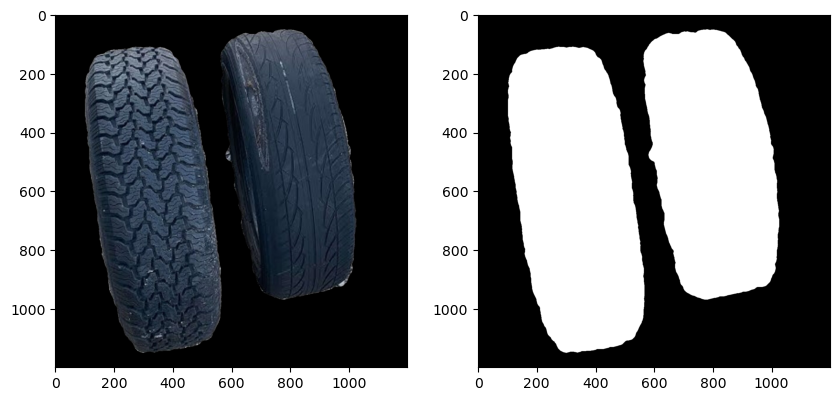

In [3]:
# Leemos la imagen en RGB
img = cv2.cvtColor(cv2.imread(archives[0], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# Leemos la otra
mask = cv2.imread(archives[1], cv2.IMREAD_GRAYSCALE) > 127
print(img.dtype)
print(mask.dtype)

# Creamos un subplot 1x2 con uy tamaño de 10x5
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray');

2
2


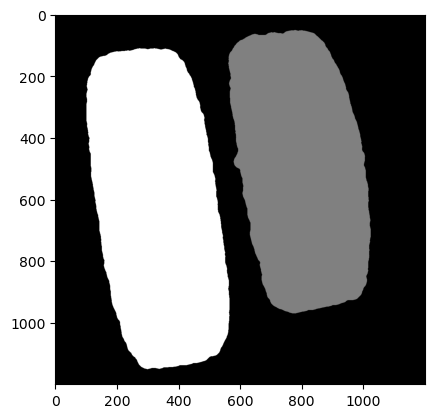

In [4]:
labels, num_labels = label(mask, return_num=True)
props = regionprops(labels)
print(len(props))
print(num_labels)
plt.imshow(labels, cmap='gray');

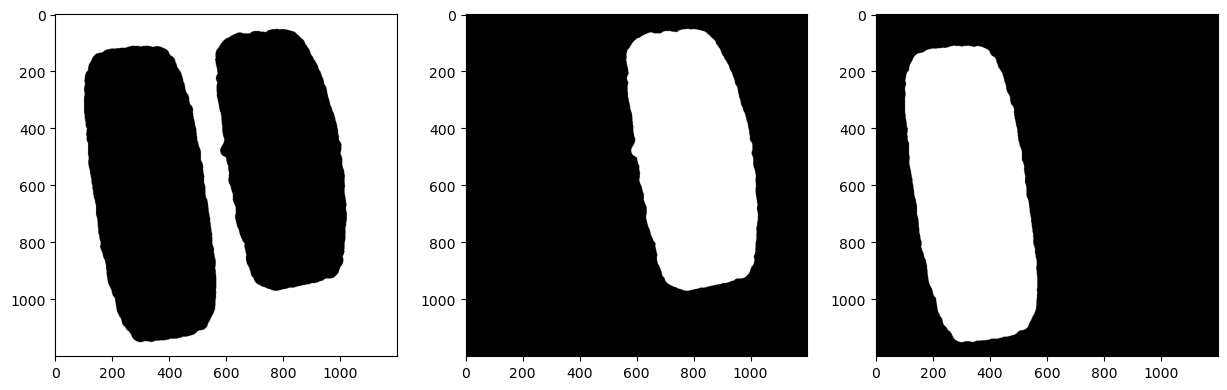

In [5]:
fig = plt.subplots(1, num_labels+1, figsize=(15, 5))
for i in range(num_labels+1):
    plt.subplot(1, num_labels+1, i+1)
    plt.imshow(labels==i, cmap='gray');

## Creación de la Pipeline para extraer características

Tras un análisis sobre las lesiones, se definió que el extractor de características contendrá las siguientes:

- **Media**, **Desviación Estándar**, **Kurtosis** y **Skewness** de cada canal de color RGB, pues las lesiones es común que tengan coloraciones rojizas (valores altos de R), coloraciones amarillentas (valores altos de R y G), y coloraciones moradas (valores altos de R y B).

- **Redondez**, **Excentricidad/Elongación**, **Solidez**, y **Relación de Aspecto** pues estas lesiones cutáneas llegan a ir desde formas muy irregulares a formas circulares o elípticas y proporciones que se guardan que pueden llegar a indicar que tan compacta es la lesión.

- **Momentos de Hu** pues son invariantes ante las transformaciones geométricas.

- **Número de componentes conexas**, pues hay lesiones que se caracterizan por ser una agrupación de pequeñas lesiones, mientras otras como costras y úlceras suelen ser de una sola componente.

- Características de segundo orden relacionadas con la textura como lo son **Contraste**, **Energía**, **Homogeneidad**, **Correlación**, **Disimilaridad** y **ASM**.

### Sub-sección de funciones

In [ ]:
""" La construcción de la función es por diversas subfunciones, 
comenzando con aquellas extraíbles de la forma con la máscara """

# Extraer momentos de Hu, trabaja directamente con la máscara booleana
def get_hu_moments(mask):
    dict_hu = {}
    moments_hu = regionprops(label(mask))[0].moments_hu
    # Agregamos un epsilon a los valores para evitar problemas con el logaritmo pero tampoco perturbar los datos
    eps = 1e-10
    moments_hu = np.round(- np.sign(moments_hu) * np.log10(np.abs(moments_hu) + eps) , decimals = 5)
    for i, hu in enumerate(moments_hu):
        dict_hu[f'hu{i}'] = hu
    return dict_hu

# Extraer características de forma, trabaja directamente con la máscara booleana
def get_shape_features(mask):
    dict_shape = {}
    mask_region = regionprops(label(mask))[0]
    dict_shape['eccentricity'] = round(mask_region.eccentricity, 5)
    dict_shape['solidity'] = round(mask_region.solidity, 5)
    dict_shape['extent'] = round(mask_region.extent, 5)
    dict_shape['aspect_ratio'] = round(mask_region.major_axis_length / mask_region.minor_axis_length, 5)
    # dict_shape['aspect_ratio2'] = mask_region.axis_major_length / mask_region.axis_minor_length
    dict_shape['roundness'] = round(4 * math.pi * mask_region.area / (mask_region.perimeter**2), 5)
    return dict_shape

In [7]:
def get_color_features(img, mask):
    dict_color = {}
    # Usamos la indexación booleana para obtener los valores de los pixeles a color correspondientes con la máscara
    r = img[:,:,0][mask]
    g = img[:,:,1][mask]
    b = img[:,:,2][mask]
    channels = [r, g, b]
    channel_symbol = ['_r', '_g', '_b']

    # Se itera para cada canal de color
    for i, img_channel in enumerate(channels):  
        # Redondeo a 5 decimales
        dict_color['mean' + channel_symbol[i]] = round(np.mean(img_channel), 5)
        dict_color['std' + channel_symbol[i]] = round(np.std(img_channel), 5)
        dict_color['kurtosis' + channel_symbol[i]] = round(kurtosis(img_channel), 5)
        dict_color['skewness' + channel_symbol[i]] = round(skew(img_channel), 5)
    return dict_color

In [8]:
# Ahora, para extraer las características de textura, se requiere la imagen en escala de grises
def get_texture_features(img_gray):
    dict_texture = {}
    """Se extraen las características de textura con la matriz de co-ocurrencia de niveles de grises, con distancias y ángulos específicos
    de manera que se analiza en 1, 3 y 5 pixeles de distancia en 4 ángulos diferentesm hasta nivel de gris (256-1), de manera simétrica y normalizada"""
    glcm = graycomatrix(img_gray, distances=[1,3,5], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4], levels = 256, symmetric = True, normed = True)
    # Como el resultado arroja una matriz, se toma le media para evitar sesgos de dirección
    dict_texture['contrast'] = round(np.mean(graycoprops(glcm, 'contrast')), 5)
    dict_texture['dissimilarity'] = round(np.mean(graycoprops(glcm, 'dissimilarity')), 5)
    dict_texture['homogeneity'] = round(np.mean(graycoprops(glcm, 'homogeneity')), 5)
    dict_texture['energy'] = round(np.mean(graycoprops(glcm, 'energy')), 5)
    dict_texture['correlation'] = round(np.mean(graycoprops(glcm, 'correlation')), 5)
    dict_texture['ASM'] = round(np.mean(graycoprops(glcm, 'ASM')), 5)
    return dict_texture

Ahora viene la funcion ***get_all_features*** que juntará la extracción de todas las características de una sola región en una imagen y su máscara

In [9]:
def get_all_features(img, mask):
    dict_out = {}
    # Extraer momentos de Hu
    dict_out.update(get_hu_moments(mask))

    # Extraer elementos de forma
    dict_out.update(get_shape_features(mask))

    # Extraer las características de color
    dict_out.update(get_color_features(img, mask))

    """ Extraer las características de textura """
    # Esto requiere primero la imagen convertida a escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dict_out.update(get_texture_features(img_gray))
    return dict_out

### Subsección para debugging

In [31]:
for i in range(1, num_labels+1):
    mask = labels == i
    print(get_hu_moments(mask))
    print(get_shape_features(mask))

{'hu0': 0.65669, 'hu1': 1.64691, 'hu2': 4.33669, 'hu3': 5.43029, 'hu4': -9.83057, 'hu5': -6.25992, 'hu6': -9.96269}
{'eccentricity': 0.90018, 'solidity': 0.97755, 'extent': 0.7752, 'aspect_ratio': 2.29611, 'roundness': 0.6543}
{'hu0': 0.61072, 'hu1': 1.4683, 'hu2': 5.8901, 'hu3': 6.63605, 'hu4': 9.99957, 'hu5': 7.61801, 'hu6': -9.99966}
{'eccentricity': 0.92674, 'solidity': 0.98666, 'extent': 0.77276, 'aspect_ratio': 2.66165, 'roundness': 0.62278}


{'contrast': 40.9451, 'dissimilarity': 1.52897, 'homogeneity': 0.82913, 'energy': 0.76907, 'correlation': 0.963, 'ASM': 0.59148}


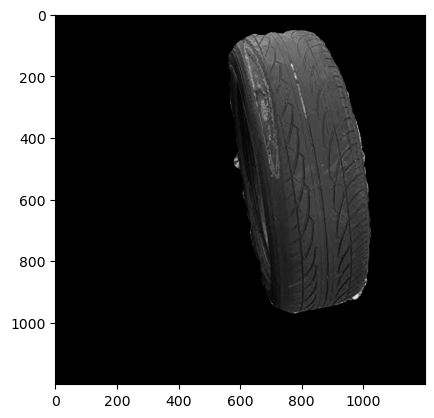

In [11]:
wheel = cv2.cvtColor((labels==1)[:,:,None]*img, cv2.COLOR_RGB2GRAY)
plt.imshow(wheel, cmap='gray');
new_dict = get_texture_features(wheel)
print(new_dict)

In [12]:
mask = labels == 1
new_dictfd = get_color_features(img, mask)
print(new_dictfd)

{'mean_r': 39.44688, 'std_r': 22.4827, 'kurtosis_r': 2.44242, 'skewness_r': 1.13567, 'mean_g': 51.40707, 'std_g': 22.38844, 'kurtosis_g': 1.66413, 'skewness_g': 0.71284, 'mean_b': 67.06347, 'std_b': 23.99245, 'kurtosis_b': 0.83605, 'skewness_b': 0.26557}


In [13]:
# Aquí hay que recordar que un 'zip' es un iterable que se consume al usarse una sola vez, por lo que para guardarlo se castea a lista
iterable_folders = list(zip(['test_segm/'], ['test_mask/']))
for segm, mask in iterable_folders:
    print(segm, mask)
    print(type(segm), type(mask))
    print(os.listdir(f"{segm}"))
    print(os.listdir(f"{mask}"))

test_segm/ test_mask/
<class 'str'> <class 'str'>
['llanta_segmentada.jpg']
['llanta_mask.jpg']


In [14]:
for segm_folder, mask_folder in iterable_folders:
    print(segm_folder, mask_folder)
    # Listamos los nombres de archivos en cada carpeta
    imgs_segmented = os.listdir(f"{segm_folder}")
    imgs_mask = os.listdir(f"{mask_folder}")
    print(imgs_segmented)
    print(imgs_mask)

test_segm/ test_mask/
['llanta_segmentada.jpg']
['llanta_mask.jpg']


In [15]:
# Creamos previamente el DataFrame
list_keys = ['hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6', 'eccentricity', 'solidity', 'extent', 'aspect_ratio', 'roundness',
             'mean_r', 'std_r', 'kurtosis_r', 'skewness_r', 'mean_g', 'std_g', 'kurtosis_g', 'skewness_g', 'mean_b', 
             'std_b', 'kurtosis_b', 'skewness_b','contrast', 'dissimilarity', 'homogeneity', 
             'energy', 'correlation', 'ASM', 'convex_components',  'class']
df = pd.DataFrame(columns=list_keys, index=[])

# Iteramos por cada par de carpetas, en el orden (segmented, mask)
counter_data = 0
for segm_folder, mask_folder in iterable_folders:

    # Listamos los nombres de archivos en cada carpeta
    imgs_segmented = os.listdir(f"{segm_folder}")
    imgs_mask = os.listdir(f"{mask_folder}")

    # Iteramos por cada par de imágenes (segmented, mask)
    for img_segm, img_mask in list(zip(imgs_segmented, imgs_mask)):

        # Obtenemos la imagen a color y la convertimos a RGB
        img = cv2.cvtColor(cv2.imread(f"{segm_folder}/{img_segm}", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        # Obtenemos la máscara en escala de grises y la binarizamos ya que esto es necesario y MUY IMPORTANTE
        mask = cv2.imread(f"{mask_folder}/{img_mask}", cv2.IMREAD_GRAYSCALE) > 127

        """ Lo siguiente es de la máscara obtener cuantas regiones conexas hay (num_labels), para saber como proceder, ya que hay imágenes de lesiones
        que contienen más de una región, por lo que se debe hacer un análisis por región y no por la imagen completa, pero conservando la etiqueta"""
        mask_labels, num_labels = label(mask, return_num=True)

        # El rango comienza desde 1 pues, la funcion 'label' pone SIEMPRE en la primera etiqueta el fondo
        for i in range(1, num_labels+1):

            # Obtenemos la máscara con solo el i-ésimo objeto detectado por 'label' originalmente
            mask_input = (mask_labels==i)*mask
            # Obtenemos la imagen con solo el i-ésimo objeto detectado por 'label' originalmente
            img_input = img*mask_input[:,:,None]
            
            """ Extraemos las características de la región i-ésima """

            # Esto recibe la imagen a color y la máscara de la región i-ésima, además de la clase a la que pertenece
            dict_out = get_all_features(img_input, mask_input)
            dict_out['convex_components'] = num_labels
            dict_out['class'] = 'wheel'

            # Por último, añadimos el diccionario a nuestro DataFrame
            df.loc[counter_data] = [dict_out[feature] for feature in dict_out.keys()]
            print(dict_out)

            # Aumentamos el contador de datos
            counter_data += 1

{'hu0': 0.65669, 'hu1': 1.64691, 'hu2': 4.33669, 'hu3': 5.4303, 'hu4': -10.32133, 'hu5': -6.26, 'hu6': -11.04722, 'eccentricity': 0.90018, 'solidity': 0.97755, 'extent': 0.7752, 'aspect_ratio': 2.29611, 'roundness': 0.6543, 'mean_r': 39.44688, 'std_r': 22.4827, 'kurtosis_r': 2.44242, 'skewness_r': 1.13567, 'mean_g': 51.40707, 'std_g': 22.38844, 'kurtosis_g': 1.66413, 'skewness_g': 0.71284, 'mean_b': 67.06347, 'std_b': 23.99245, 'kurtosis_b': 0.83605, 'skewness_b': 0.26557, 'contrast': 40.9451, 'dissimilarity': 1.52897, 'homogeneity': 0.82913, 'energy': 0.76907, 'correlation': 0.963, 'ASM': 0.59148, 'convex_components': 2, 'class': 'wheel'}
{'hu0': 0.61072, 'hu1': 1.4683, 'hu2': 5.89014, 'hu3': 6.63624, 'hu4': 13.00227, 'hu5': 7.61981, 'hu6': -13.11112, 'eccentricity': 0.92674, 'solidity': 0.98666, 'extent': 0.77276, 'aspect_ratio': 2.66165, 'roundness': 0.62278, 'mean_r': 50.7246, 'std_r': 27.49434, 'kurtosis_r': 0.74859, 'skewness_r': 0.78818, 'mean_g': 63.70305, 'std_g': 27.63136, 'k

In [16]:
df.head()
# Convertimos el DataFrame a un archivo CSV
df.to_csv('features_wheel_test3.csv', index=False)

In [17]:
print(f"Dan un total de: {len(list_keys)} características extraídas")
print(f"Dan un total de: {len(dict_out.keys())} características extraídas")

Dan un total de: 32 características extraídas
Dan un total de: 32 características extraídas


### Sub-sección para el caso general 

In [ ]:
folders_segm = os.listdir("segmented/")
folders_mask = os.listdir("mask/")
iterable_folders = zip(folders_segm, folders_mask)
print(iterable_folders)

In [ ]:
l1 = ['costra_segm', 'ulcera_segm', 'maculas_segm', 'nodulos_segm', 'vesiculas_segm']
l2 = ['costra_mask', 'ulcera_mask', 'maculas_mask', 'nodulos_mask', 'vesiculas_mask']

"""Creamos ahora una lista donde cada elemento es la pareja de folders 
(segmented, mask) correspondiente. Aquí hay que recordar que un 'zip' 
es un iterable que se consume al usarse una sola vez, por lo que para 
guardarlo se castea a lista """
iterable_folders = list(zip(l1, l2))
for segm, mask in iterable_folders:
    print(segm, mask)
print(iterable_folders)

costra_segm costra_mask
ulcera_segm ulcera_mask
maculas_segm maculas_mask
nodulos_segm nodulos_mask
vesiculas_segm vesiculas_mask


In [13]:
iterable_folders = list(zip(["Ulcers_segmented/"], ["Ulcers_mask/"]))
print(iterable_folders)

[('Ulcers_segmented/', 'Ulcers_mask/')]


In [15]:
ulcers_segm = sorted(os.listdir("Ulcers_segmented"))
ulcers_mask = sorted(os.listdir("Ulcers_mask"))
iterable_images = list(zip(ulcers_segm, ulcers_mask))
print(type(ulcers_segm), type(ulcers_mask))
for segm, mask in iterable_images:
    print(segm, mask)

<class 'list'> <class 'list'>
U10_segmented.png U10_mask.png
U11_segmented.png U11_mask.png
U12_segmented.png U12_mask.png
U13_segmented.png U13_mask.png
U14_segmented.png U14_mask.png
U15_segmented.png U15_mask.png
U16_segmented.png U16_mask.png
U17_segmented.png U17_mask.png
U18_segmented.png U18_mask.png
U19_segmented.png U19_mask.png
U1_segmented.png U1_mask.png
U20_segmented.png U20_mask.png
U21_segmented.png U21_mask.png
U22_segmented.png U22_mask.png
U23_segmented.png U23_mask.png
U24_segmented.png U24_mask.png
U25_segmented.png U25_mask.png
U26_segmented.png U26_mask.png
U27_segmented.png U27_mask.png
U28_segmented.png U28_mask.png
U29_segmented.png U29_mask.png
U2_segmented.png U2_mask.png
U30_segmented.png U30_mask.png
U31_segmented.png U31_mask.png
U32_segmented.png U32_mask.png
U33_segmented.png U33_mask.png
U34_segmented.png U34_mask.png
U35_segmented.png U35_mask.png
U36_segmented.png U36_mask.png
U37_segmented.png U37_mask.png
U38_segmented.png U38_mask.png
U3_segmented.

In [ ]:
def features_extract(iterable_folders_object):
    # Creamos previamente el DataFrame
    list_keys = ['hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6', 'eccentricity', 'solidity', 'extent', 'aspect_ratio', 'roundness', 'mean_r', 'std_r', 
                'kurtosis_r', 'skewness_r', 'mean_g', 'std_g', 'kurtosis_g', 'skewness_g', 'mean_b', 
                'std_b', 'kurtosis_b', 'skewness_b', 'contrast', 'dissimilarity', 'homogeneity', 
                'energy', 'correlation', 'ASM', 'convex_components', 'class']
    df = pd.DataFrame(columns=list_keys)


    # Contador de filas de datos para el DataFrame
    counter_row = 0

    # Iteramos por cada par de carpetas, en el orden (segmented, mask)
    for segm_folder, mask_folder in iterable_folders_object:

        # Listamos los nombres de archivos en cada carpeta
        imgs_segmented = sorted(os.listdir(f"{segm_folder}"))
        imgs_mask = sorted(os.listdir(f"{mask_folder}"))

        # Iteramos por cada par de imágenes (segmented, mask)
        for img_segm, img_mask in list(zip(imgs_segmented, imgs_mask)):
            try:
                # Obtenemos la imagen a color y la convertimos a RGB
                img = cv2.cvtColor(cv2.imread(f"{segm_folder}/{img_segm}", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
                # Obtenemos la máscara en escala de grises y la binarizamos ya que esto es necesario y MUY IMPORTANTE
                mask = cv2.imread(f"{mask_folder}/{img_mask}", cv2.IMREAD_GRAYSCALE) > 127

                """ Lo siguiente es de la máscara obtener cuantas regiones conexas hay (num_labels), para saber como proceder, ya que hay imágenes de lesiones
                que contienen más de una región, por lo que se debe hacer un análisis por región y no por la imagen completa, pero conservando la etiqueta"""
                mask_labels, num_labels = label(mask, return_num=True)

                # El rango comienza desde 1 pues, la funcion 'label' pone SIEMPRE en la primera etiqueta el fondo
                for i in range(1, num_labels+1):

                    # Obtenemos la máscara con solo el i-ésimo objeto detectado por 'label' originalmente
                    mask_input = (mask_labels==i)*mask
                    # Obtenemos la imagen con solo el i-ésimo objeto detectado por 'label' originalmente
                    img_input = img*mask_input[:,:,None]
                    
                    """ Extraemos las características de la región i-ésima """

                    # Esto recibe la imagen a color y la máscara de la región i-ésima, además de la clase a la que pertenece
                    dict_out = get_all_features(img_input, mask_input)
                    dict_out['convex_components'] = num_labels
                    dict_out['class'] = 'wheel'

                    # Por último, añadimos el diccionario a nuestro DataFrame
                    df.loc[counter_row] = [dict_out[feature] for feature in dict_out.keys()]
                    
                    # Aumentamos el contador de datos
                    counter_row += 1
            except:
                print(f"Error en la imagen {img_segm} ó máscara {img_mask}")
                continue
    counter_row = 0
    return df

In [18]:
features_dataframe = features_extract(iterable_folders)
features_dataframe.head()

,hu0,hu1,hu2,hu3,hu4,hu5,hu6,eccentricity,solidity,extent,...,kurtosis_b,skewness_b,contrast,dissimilarity,homogeneity,energy,correlation,ASM,convex_components,class
0,0.65753,1.67513,3.82056,4.68261,9.61119,-6.02055,-8.90152,0.89199,0.90915,0.66325,...,0.36689,0.81686,138.82018,2.80376,0.88994,0.88263,0.93852,0.77905,1,wheel
1,0.79232,3.21349,6.40214,8.40162,-10.00000,-9.71005,10.00000,0.51562,0.97858,0.72038,...,-0.12894,-0.42521,42.12168,0.27428,0.99357,0.99293,0.90268,0.98591,1,wheel
2,0.72549,2.05758,3.60638,4.76740,9.08401,6.07779,9.02569,0.81507,0.94468,0.67900,...,0.57852,0.35154,31.00476,0.49106,0.97063,0.96541,0.93653,0.93201,1,wheel
3,0.76545,2.45990,4.96321,6.99150,9.99971,-8.42040,9.99964,0.71483,0.97396,0.85075,...,0.28521,0.52318,88.18458,1.24146,0.96150,0.95945,0.91388,0.92054,1,wheel
4,0.77967,2.69670,4.62878,6.23957,9.99518,7.90541,-9.99225,0.65204,0.97663,0.74013,...,-0.30523,0.56728,199.91604,2.45019,0.86366,0.83793,0.95363,0.70214,1,wheel


In [19]:
# Convertimos el DataFrame a un archivo CSV
features_dataframe.to_csv('features_ulcers.csv', index=False)

In [25]:
# Creamos previamente el DataFrame
list_keys = ['hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6', 'eccentricity', 'solidity', 'extent', 'aspect_ratio', 'roundness', 'mean_r', 'std_r', 
             'kurtosis_r', 'skewness_r', 'mean_g', 'std_g', 'kurtosis_g', 'skewness_g', 'mean_b', 
             'std_b', 'kurtosis_b', 'skewness_b', 'contrast', 'dissimilarity', 'homogeneity', 
             'energy', 'correlation', 'ASM', 'convex_components', 'class']
df = pd.DataFrame(columns=list_keys)


# Contador de filas de datos para el DataFrame
counter_row = 0

# Iteramos por cada par de carpetas, en el orden (segmented, mask)
for segm_folder, mask_folder in iterable_folders:

    # Listamos los nombres de archivos en cada carpeta
    imgs_segmented = sorted(os.listdir(f"{segm_folder}"))
    imgs_mask = sorted(os.listdir(f"{mask_folder}"))

    # Iteramos por cada par de imágenes (segmented, mask)
    for img_segm, img_mask in list(zip(imgs_segmented, imgs_mask)):

        # Obtenemos la imagen a color y la convertimos a RGB
        img = cv2.cvtColor(cv2.imread(f"{segm_folder}/{img_segm}", cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        # Obtenemos la máscara en escala de grises y la binarizamos ya que esto es necesario y MUY IMPORTANTE
        mask = cv2.imread(f"{mask_folder}/{img_mask}", cv2.IMREAD_GRAYSCALE) > 127

        """ Lo siguiente es de la máscara obtener cuantas regiones conexas hay (num_labels), para saber como proceder, ya que hay imágenes de lesiones
        que contienen más de una región, por lo que se debe hacer un análisis por región y no por la imagen completa, pero conservando la etiqueta"""
        mask_labels, num_labels = label(mask, return_num=True)

        # El rango comienza desde 1 pues, la funcion 'label' pone SIEMPRE en la primera etiqueta el fondo
        for i in range(1, num_labels+1):

            # Obtenemos la máscara con solo el i-ésimo objeto detectado por 'label' originalmente
            mask_input = (mask_labels==i)*mask
            # Obtenemos la imagen con solo el i-ésimo objeto detectado por 'label' originalmente
            img_input = img*mask_input[:,:,None]
            
            """ Extraemos las características de la región i-ésima """

            # Esto recibe la imagen a color y la máscara de la región i-ésima, además de la clase a la que pertenece
            dict_out = get_all_features(img_input, mask_input)
            dict_out['convex_components'] = num_labels
            dict_out['class'] = 'wheel'

            # Por último, añadimos el diccionario a nuestro DataFrame
            df.loc[counter_row] = [dict_out[feature] for feature in dict_out.keys()]
            
            # Aumentamos el contador de datos
            counter_row += 1
counter_row = 0

/tmp/ipykernel_21768/729490559.py:8: RuntimeWarning: divide by zero encountered in log10
  moments_hu = np.round(- np.sign(moments_hu) * np.log10(np.abs(moments_hu)), decimals = 5)
/tmp/ipykernel_21768/729490559.py:8: RuntimeWarning: invalid value encountered in multiply
  moments_hu = np.round(- np.sign(moments_hu) * np.log10(np.abs(moments_hu)), decimals = 5)
/tmp/ipykernel_21768/729490559.py:8: RuntimeWarning: divide by zero encountered in log10
  moments_hu = np.round(- np.sign(moments_hu) * np.log10(np.abs(moments_hu)), decimals = 5)
/tmp/ipykernel_21768/729490559.py:8: RuntimeWarning: invalid value encountered in multiply
  moments_hu = np.round(- np.sign(moments_hu) * np.log10(np.abs(moments_hu)), decimals = 5)
/tmp/ipykernel_21768/729490559.py:8: RuntimeWarning: divide by zero encountered in log10
  moments_hu = np.round(- np.sign(moments_hu) * np.log10(np.abs(moments_hu)), decimals = 5)
/tmp/ipykernel_21768/729490559.py:8: RuntimeWarning: invalid value encountered in multiply


In [26]:
df.head()
# Convertimos el DataFrame a un archivo CSV
df.to_csv('ulcers_test.csv', index=False)